In [47]:
import sys
sys.path.append("..")

import os
import json
import numpy as np
from scipy.special import softmax
from scipy.integrate import simpson
from scipy.optimize import root

from tabulate import tabulate

import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [40]:
from test_model import plot_cm, model_dir, output_dir
from cnn_data import load_data

In [41]:
task_name = "scalar1"

In [4]:
print(f"Loading data for task {task_name}...")
X, Y = load_data(task_name, get_all=True)
print(f"Loading model...")
cnn = keras.models.load_model(f"{model_dir}/{task_name}_cnn")

y_pred = cnn.predict(X, batch_size=100)

Loading data for task scalar1...
load_data from datafile /data/wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /data/wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /data/wifeng/photon-jet/data/h5/scalar1_40-250GeV_100k.h5
Loading model...


2024-01-16 00:58:33.344754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:88:00.0, compute capability: 7.5
2024-01-16 00:58:33.345783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9804 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5
2024-01-16 00:58:33.346635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2024-01-16 00:58:33.347482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

3000/3000 [==============================] - 5s 1ms/step


In [5]:
y_pred.shape

(300000, 3)

In [6]:
y_pred[:10]

array([[  2.4368527,  -3.4362452,  -4.2294054],
       [  2.2906039,  -3.3082483,  -4.43527  ],
       [ 11.566147 , -11.426194 ,   8.621298 ],
       [  3.1269078,  -4.040181 ,  -3.2580605],
       [  9.56661  ,  -9.676201 ,   5.8066807],
       [  1.8291234,  -3.385836 ,  -4.9179144],
       [  1.8291234,  -3.385836 ,  -4.9179144],
       [  7.9418545,  14.348602 ,  -3.663233 ],
       [  7.110714 ,  -7.526804 ,   2.3496792],
       [  2.649509 ,  -3.622362 ,  -3.9300632]], dtype=float32)

In [29]:
N = round(len(y_pred) / 3)
sig_probs = softmax(y_pred[(2 * N):], axis=1)[:,2]
bg_probs = softmax(np.concatenate([y_pred[:N], y_pred[N:(2 * N)]]), axis=1)[:,2]

In [30]:
print("Signal last layer:", sig_probs.shape)
print(sig_probs[:5])
print("Background last layer:", bg_probs.shape)
print(bg_probs[:5])

Signal last layer: (100000,)
[1. 1. 1. 1. 1.]
Background last layer: (200000,)
[0.00126797 0.00119362 0.04998052 0.00168259 0.02275551]


In [31]:
def get_eff(probs, thresh):
    """
    Proportion of probabilities identified with label 2.
    """
    thresh = np.array(thresh)
    n_samples = len(probs)
    
    if len(thresh.shape) > 0:
        assert(len(thresh.shape) == 1)
        shape = (len(thresh), len(probs))
        probs = np.broadcast_to(probs, shape)
        thresh = np.broadcast_to(thresh, shape[::-1]).T
        return np.sum(probs >= thresh, axis=1) / n_samples

    return np.sum(probs >= thresh) / n_samples

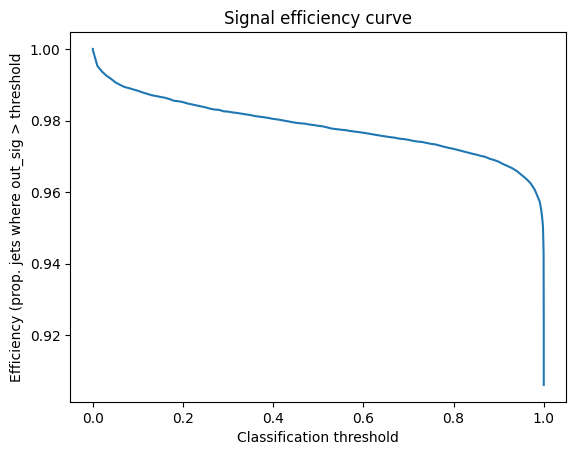

In [63]:
thresh = np.concatenate([
    np.linspace(0, 0.0001, 1000),
    np.linspace(0.0001, 0.99, 100),
    (1 - np.logspace(np.log10(1 - 0.99), -10, 1000)),
    [1]
])

sig_eff_curve = get_eff(sig_probs, thresh)
plt.title("Signal efficiency curve")
plt.xlabel("Classification threshold")
plt.ylabel("Efficiency (prop. jets where out_sig > threshold")
plt.plot(thresh[:-20], sig_eff_curve[:-20], label="Signal");

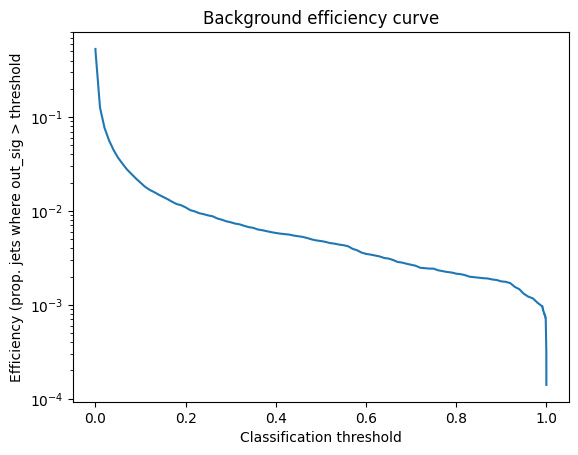

In [65]:
bg_eff_curve = get_eff(bg_probs, thresh)
plt.title("Background efficiency curve")
plt.xlabel("Classification threshold")
plt.ylabel("Efficiency (prop. jets where out_sig > threshold")
plt.plot(thresh[20:-20], bg_eff_curve[20:-20], label="Background");
plt.yscale("log")

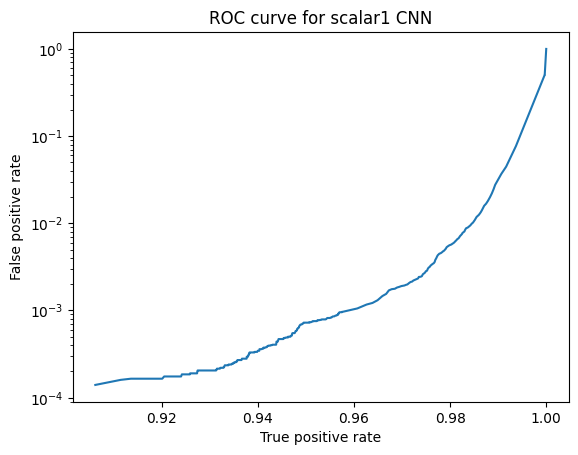

In [43]:
plt.title(f"ROC curve for {task_name} CNN")
plt.plot(sig_eff_curve[:], bg_eff_curve[:])
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.yscale("log")

In [44]:
def get_thresh(probs, desired_eff):
    return root(lambda x: get_eff(probs, x) - desired_eff, 0.5).x[0]

In [45]:
table = []
working_pts = [0.5, 0.9, 0.99, 0.999]
for desired_eff in working_pts:
    thresh = get_thresh(sig_probs, desired_eff)
    sig_eff = get_eff(sig_probs, thresh)
    inv_bg_eff = 1 / get_eff(bg_probs, thresh)
    table.append([thresh, sig_eff, inv_bg_eff])

In [60]:
get_eff(sig_probs, 0.84)

0.97078

In [48]:
# print(tabulate(table, headers=["Thresh", "Sig_eff", "inv bg_eff"]))
print(f"Efficiency analysis table for {task_name} PFN")
print(tabulate(
    table,
    headers=["Classification threshold", r"$\varepsilon_s$", r"$1/\varepsilon_b$"],
    floatfmt=".3f"
))

Efficiency analysis table for scalar1 PFN
  Classification threshold    $\varepsilon_s$    $1/\varepsilon_b$
--------------------------  -----------------  -------------------
                     1.000              0.906             7142.857
                     1.000              0.906             7142.857
                     0.060              0.990               31.437
                    -0.546              1.000                1.000
